# Authorship verification experiment using the Kaggle Blog Corpus with Gemini

In [1]:
import os 
import sys
sys.path.append(os.path.abspath('..'))

In [2]:
import pandas as pd
import numpy as np

In [3]:
from credentials import get_credentials_gemini
API_KEY = get_credentials_gemini()
os.environ["GEMINI_API_KEY"] = API_KEY

import google.generativeai as genai


genai.configure(api_key=os.getenv("GEMINI_API_KEY"))


In [4]:
# Load the training and test sets
train_path = "./data/authorship_verification_kaggle_data_2_train.pkl"
test_path = "./data/authorship_verification_kaggle_data_2_test.pkl"

df_train = pd.read_pickle(train_path)
df_test = pd.read_pickle(test_path)

In [5]:
#Create training string

# Set random seed for reproducibility
np.random.seed(42)

# Get unique author IDs
author_ids = df_train['id'].unique()

# Dictionary to store concatenated texts
author_samples = {}

for author_id in author_ids:
    # Sample 30 texts for this author
    sample_texts = df_train[df_train['id'] == author_id]['text'].sample(n=35, random_state=42)
    # Concatenate into a single string (separated by newlines or spaces)
    concatenated = "\n\n".join(sample_texts)
    author_samples[author_id] = concatenated


In [6]:
# Pick a random text from the test sample and get its author id
test_text = df_test['text'].sample(n=1, random_state=42).values[0]
test_author_id = df_test[df_test['text'] == test_text]['id'].values[0]


In [7]:
# Create the template prompt

prompt = f"""
You are an expert in linguistic analysis and authorship attribution. Your task is to analyze authorship--i.e. idiolectal--markers that the \
texts reveal about their authors.


You will be provided with:
1. Training samples from 2 different authors, identified only by an unique id number (734562 and 449628);
2. A new text whose author you need to identify between those two authors

Guideline for analysis:
- Just use state of the art techniques to attribute authorship

Author's id 734562 samples:
{author_samples[author_ids[0]]}

Author's id 449628 samples:
{author_samples[author_ids[1]]}

New text to analyze:
{test_text}

Give as your answer only the author's id number and nothing else, like so: NNNNNN. Do not include any other text.

"""

In [8]:
def get_completion(prompt: str, model: str = "gemini-2.0-flash") -> str:
    '''
    Generate a completion for a given prompt using the Gemini API
    Args:
        prompt: The prompt to generate a completion for
        model: The model to use for the completion
    Returns:
        The completion for the prompt
    '''
    model = genai.GenerativeModel(model)
    response = model.generate_content(prompt)
    return response.text

In [9]:
first_prediction = get_completion(prompt)
print(first_prediction)

734562



In [10]:
# Check if the prediction is accurate
# Get the actual author of the random tweet
actual_author = str(test_author_id).lower()

# Get the predicted author from the model's response
predicted_author = first_prediction.strip().lower()

# Check if the prediction matches the actual author
is_correct = predicted_author == actual_author

print(f"Actual author: {actual_author}")
print(f"Predicted author: {predicted_author}")
print(f"Prediction is correct: {is_correct}")

# Calculate accuracy (1 for correct, 0 for incorrect)
accuracy = 1 if is_correct else 0
print(f"Accuracy: {accuracy}")

Actual author: 734562
Predicted author: 734562
Prediction is correct: True
Accuracy: 1


In [11]:
# Sample 100 test blog posts for evaluation
n_samples = 100
sampled_posts = df_test.sample(n=n_samples, random_state=42).reset_index(drop=True)
print(f'Created sample dataset with {len(sampled_posts)} blog posts')
print('Sample distribution:')
print(sampled_posts['id'].value_counts())

Created sample dataset with 100 blog posts
Sample distribution:
id
449628    60
734562    40
Name: count, dtype: int64


In [12]:
def normalize_author_id(author_id):
    return str(author_id).strip()

In [13]:
import time

batch_size = 10
total_batches = len(sampled_posts) // batch_size + (1 if len(sampled_posts) % batch_size > 0 else 0)

results = []  # (idx, text, actual_author, predicted_author)
errors = []
print(f'Starting processing of {len(sampled_posts)} blog posts in {total_batches} batches')

for batch in range(total_batches):
    start_idx = batch * batch_size
    end_idx = min((batch + 1) * batch_size, len(sampled_posts))
    batch_errors = 0
    for idx in range(start_idx, end_idx):
        row = sampled_posts.iloc[idx]
        blog_text = row['text']
        actual_author = normalize_author_id(row['id'])
        prompt = f"""
You are an expert in linguistic analysis and authorship attribution. Your task is to analyze authorship--i.e. idiolectal--markers that the texts reveal about their authors.

You will be provided with:
1. Training samples from 2 different authors, identified only by an unique id number (734562 and 449628);
2. A new text whose author you need to identify between those two authors

Guideline for analysis:
- Just use state of the art techniques to attribute authorship

Author's id 734562 samples:
{author_samples[author_ids[0]]}

Author's id 449628 samples:
{author_samples[author_ids[1]]}

New text to analyze:
{blog_text}

Give as your answer only the author's id number and nothing else, like so: NNNNNN. Do not include any other text.
"""
        max_retries = 3
        retry_delay = 120
        for retry in range(max_retries):
            try:
                raw_prediction = get_completion(prompt).strip()
                prediction = normalize_author_id(raw_prediction)
                if prediction in [normalize_author_id(author_ids[0]), normalize_author_id(author_ids[1])]:
                    results.append((idx, blog_text, actual_author, prediction))
                else:
                    batch_errors += 1
                    errors.append((idx, f'Invalid prediction: {raw_prediction}'))
                time.sleep(10)
                break
            except Exception as e:
                if retry < max_retries - 1:
                    time.sleep(retry_delay)
                else:
                    batch_errors += 1
                    errors.append((idx, str(e)))
                    break
    print(f'Completed batch {batch + 1}/{total_batches} (posts {start_idx}-{end_idx-1})')
    if batch_errors > 0:
        print(f'  ⚠️  {batch_errors} errors in this batch')
    if batch < total_batches - 1:
        print('  Taking a 30 second break...')
        time.sleep(30)

print('\nProcessing complete!')
print(f'Successfully processed: {len(results)} blog posts')
if errors:
    print(f'Total errors: {len(errors)}')

Starting processing of 100 blog posts in 10 batches
Completed batch 1/10 (posts 0-9)
  Taking a 30 second break...
Completed batch 2/10 (posts 10-19)
  Taking a 30 second break...
Completed batch 3/10 (posts 20-29)
  Taking a 30 second break...
Completed batch 4/10 (posts 30-39)
  Taking a 30 second break...
Completed batch 5/10 (posts 40-49)
  Taking a 30 second break...
Completed batch 6/10 (posts 50-59)
  Taking a 30 second break...
Completed batch 7/10 (posts 60-69)
  Taking a 30 second break...
Completed batch 8/10 (posts 70-79)
  Taking a 30 second break...
Completed batch 9/10 (posts 80-89)
  Taking a 30 second break...
Completed batch 10/10 (posts 90-99)

Processing complete!
Successfully processed: 100 blog posts


Overall accuracy: 94.00% (94/100)
Accuracy for 734562: 87.50% (35/40)
Accuracy for 449628: 98.33% (59/60)


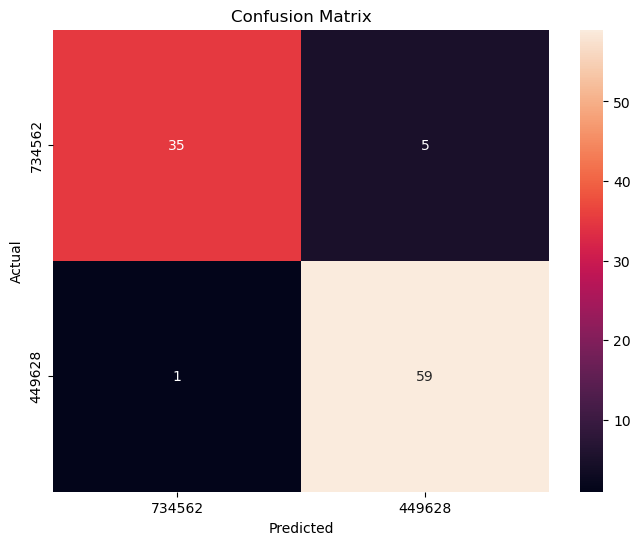

SOME CORRECTLY CLASSIFIED EXAMPLES:\n
Blog:            oh stop it yel.  hardly anyone blogs here - let the ones who will be here, be here. shees...\nActual: 734562 | Predicted: 734562\n------------------------------------------------------------
Blog:          urlLink Nine Things You Should Never Say In An Interview    Avoid the interview pitfalls as...\nActual: 449628 | Predicted: 449628\n------------------------------------------------------------
Blog:            I had the same though when I read it.         ...\nActual: 734562 | Predicted: 734562\n------------------------------------------------------------
Blog:             'Every generation has underestimated the potential for finding new ideas...Possibilities...\nActual: 449628 | Predicted: 449628\n------------------------------------------------------------
Blog:            Well, you could practice both at the same time...... Provided that the one you are dating...\nActual: 734562 | Predicted: 734562\n--------------------------

In [14]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if results:
    predicted_authors = [r[3] for r in results]
    actual_authors = [r[2] for r in results]
    correct = sum(p == a for p, a in zip(predicted_authors, actual_authors))
    final_accuracy = correct / len(predicted_authors)
    print(f'Overall accuracy: {final_accuracy:.2%} ({correct}/{len(predicted_authors)})')
    # Per-author accuracy
    for author in [normalize_author_id(author_ids[0]), normalize_author_id(author_ids[1])]:
        author_cases = [(p == author) for _, _, a, p in results if a == author]
        if author_cases:
            author_accuracy = sum(author_cases) / len(author_cases)
            print(f'Accuracy for {author}: {author_accuracy:.2%} ({sum(author_cases)}/{len(author_cases)})')
    # Confusion matrix
    valid_results = [(a, p) for _, _, a, p in results if p in [normalize_author_id(author_ids[0]), normalize_author_id(author_ids[1])]]
    if valid_results:
        y_true = [r[0] for r in valid_results]
        y_pred = [r[1] for r in valid_results]
        cm = confusion_matrix(y_true, y_pred, labels=[normalize_author_id(author_ids[0]), normalize_author_id(author_ids[1])])
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=[str(author_ids[0]), str(author_ids[1])], yticklabels=[str(author_ids[0]), str(author_ids[1])])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    # Qualitative examples
    results_df = pd.DataFrame(results, columns=['idx', 'text', 'actual_author', 'predicted_author'])
    correct_cases = results_df[results_df['actual_author'] == results_df['predicted_author']]
    incorrect_cases = results_df[results_df['actual_author'] != results_df['predicted_author']]
    n_samples = 10
    sampled_correct = correct_cases.sample(n=min(n_samples, len(correct_cases)), random_state=42)
    sampled_incorrect = incorrect_cases.sample(n=min(n_samples, len(incorrect_cases)), random_state=42)
    print('SOME CORRECTLY CLASSIFIED EXAMPLES:\\n')
    for _, row in sampled_correct.iterrows():
        print(f'Blog: {row["text"][:100]}...\\nActual: {row["actual_author"]} | Predicted: {row["predicted_author"]}\\n{"-"*60}')
    print('\\nSOME INCORRECTLY CLASSIFIED EXAMPLES:\\n')
    for _, row in sampled_incorrect.iterrows():
        print(f'Blog: {row["text"][:100]}...\\nActual: {row["actual_author"]} | Predicted: {row["predicted_author"]}\\n{"-"*60}')

In [15]:
# Save results as html for qualitative analysis
sampled_correct['case'] = 'correct'
sampled_incorrect['case'] = 'incorrect'
qualitative_df = pd.concat([sampled_correct, sampled_incorrect])
# Save to the "data" folder
qualitative_df.to_html("./data/gemini_qualitative_inspection.html", index=False)



In [16]:
# Ask Gemini to explain the results

prompt = f"""
A Large Language Model was tasked with attributing authorship to blog posts from two authors, identified only by an unique id number (734562 and 449628).
Generally, the model performed well, with about 90% accuracy. However, it made some mistakes.

You will be provided with:
1. A list of texts that were correctly classified by the model
2. A list of texts that were incorrectly classified by the model

Your task and guidelines:
Act as a linguistic expert. Your task is to explain the performance of the model. Think globally about the dataset and the discursive patterns that emerge. Give more focus/
in trying to understand the mistakes the model made.
Do not focus on individual tweets, but rather on the broader discursive patterns. Try, when possible, to use examples to illustrate those patterns.

Here are the texts that were correctly classified by the model:
<correct_cases>
{sampled_correct['text'].to_string(index=False)}
</correct_cases>

Here are the texts that were incorrectly classified by the model:
<incorrect_cases>
{sampled_incorrect['text'].to_string(index=False)}
</incorrect_cases>

Your answer should be a two to three paragraph explanation about the performance of the model, following the guidelines above.
"""

In [17]:
from IPython.display import display, HTML

qualitative_explanation = get_completion(prompt)
display(HTML(qualitative_explanation))
